In [9]:
import cv2
import sklearn
from sklearn.cluster import KMeans
import scipy.cluster.vq as vq
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import struct
import pickle
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import itertools
from sklearn import neighbors, metrics
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [11]:
def extract_DenseSift_descriptors(img):

    gray = img 

    sift = cv2.xfeatures2d.SIFT_create()
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, gray.shape[0], disft_step_size)
                for x in range(0, gray.shape[1], disft_step_size)]

    keypoints, descriptors = sift.compute(gray, keypoints)

    return [keypoints, descriptors]

In [12]:
def svm_classifier(x_train, y_train, x_test=None, y_test=None):

    C_range = 10.0 ** np.arange(-3, 3)
    gamma_range = 10.0 ** np.arange(-3, 3)
    param_grid = dict(gamma=gamma_range.tolist(), C=C_range.tolist())

    # Grid search for C, gamma, 5-fold CV
    print("Tuning hyper-parameters\n")
    clf = GridSearchCV(svm.SVC(), param_grid, cv=5, n_jobs=-2)
    clf.fit(x_train, y_train)
    print("Best parameters set found on development set:\n")
    print(clf.best_estimator_)
    print("\nGrid scores on development set:\n")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf.predict(x_test)
    #print(classification_report(y_true, y_pred, target_names=get_label()))
    print(classification_report(y_true, y_pred))
    return y_true, y_pred

In [13]:
def build_codebook(X, voc_size):

    features = np.vstack((descriptor for descriptor in X))
    kmeans = KMeans(n_clusters=voc_size, n_jobs=-2)
    kmeans.fit(features)
    codebook = kmeans.cluster_centers_.squeeze()
    print("Codebook Building Complete")
    return codebook

def input_vector_encoder(feature, codebook):
    """
    Input all the local feature of the image
    Pooling (encoding) by codebook and return
    """
    code, _ = vq.vq(feature, codebook)
    word_hist, bin_edges = np.histogram(code, bins=range(codebook.shape[0] + 1), normed=True)
    return word_hist


In [14]:
def build_spatial_pyramid(image, descriptor, level):
    """
    Rebuild the descriptors according to the level of pyramid
    """
    assert 0 <= level <= 2, "Level Error"
    step_size = DSIFT_STEP_SIZE
    #from utils import DSIFT_STEP_SIZE as s
    s = 4
    assert s == step_size, "step_size must equal to DSIFT_STEP_SIZE                            in utils.extract_DenseSift_descriptors()"
    h = image.shape[0] // step_size
    w = image.shape[1] // step_size
    idx_crop = np.array(range(len(descriptor))).reshape(h,w)
    size = idx_crop.itemsize
    height, width = idx_crop.shape
    bh, bw = 2**(3-level), 2**(3-level)
    shape = (height//bh, width//bw, bh, bw)
    strides = size * np.array([width*bh, bw, width, 1])
    crops = np.lib.stride_tricks.as_strided(
            idx_crop, shape=shape, strides=strides)
    des_idxs = [col_block.flatten().tolist() for row_block in crops
                for col_block in row_block]
    pyramid = []
    for idxs in des_idxs:
        pyramid.append(np.asarray([descriptor[idx] for idx in idxs]))
    return pyramid


# In[3]:


def spatial_pyramid_matching(image, descriptor, codebook, level):
    pyramid = []
    if level == 0:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        return np.asarray(code).flatten()
    if level == 1:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.5 * np.asarray(code[0]).flatten()
        code_level_1 = 0.5 * np.asarray(code[1:]).flatten()
        return np.concatenate((code_level_0, code_level_1))
    if level == 2:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        pyramid += build_spatial_pyramid(image, descriptor, level=2)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.25 * np.asarray(code[0]).flatten()
        code_level_1 = 0.25 * np.asarray(code[1:5]).flatten()
        code_level_2 = 0.5 * np.asarray(code[5:]).flatten()
        return np.concatenate((code_level_0, code_level_1, code_level_2))


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    accuracy = np.mean(np.max(cm,axis=1))
    print(accuracy)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return accuracy

In [16]:
root = './data'
download = True

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)

In [17]:
raw_train = read_idx("data/raw/train-images-idx3-ubyte")
train_data = np.reshape(raw_train,(60000,28*28))
train_label = read_idx("data/raw/train-labels-idx1-ubyte")

raw_test = read_idx("data/raw/t10k-images-idx3-ubyte")
test_data = np.reshape(raw_test,(10000,28*28))
test_label = read_idx("data/raw/t10k-labels-idx1-ubyte")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [18]:
x_train = []
y_train = train_label
x_test = []
y_test = test_label

for i in range(len(train_data)):
    img1 = train_data[i].reshape((28,28))
    img1 = np.uint8(img1*255)
    x_train.append(img1)

for j in range(len(test_data)):
    img2 = test_data[j].reshape((28,28))
    img2 = np.uint8(img2*255)
    x_test.append(img2)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

In [19]:
x_train = x_train[:10000,:,:]
x_test = x_test[:2000,:,:]
y_train = y_train[:10000]
y_test = y_test[:2000]
print (x_train.shape)
print (x_test.shape)


(10000, 28, 28)
(2000, 28, 28)


In [28]:
VOC_SIZE = 100
PYRAMID_LEVEL = 1
DSIFT_STEP_SIZE = 4

x_train_feature = [extract_DenseSift_descriptors(img) for img in x_train]
x_test_feature = [extract_DenseSift_descriptors(img) for img in x_test]
x_train_kp, x_train_des = zip(*x_train_feature)
x_test_kp, x_test_des = zip(*x_test_feature)
print ("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
print ("Codebook Size: {:d}".format(VOC_SIZE))
print ("Pyramid level: {:d}".format(PYRAMID_LEVEL))
print ("Building the codebook, it will take some time")
codebook = build_codebook(x_train_des, VOC_SIZE)

Train/Test split: 10000/2000
Codebook Size: 100
Pyramid level: 1
Building the codebook, it will take some time


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/conda/lib/python3.6/site-packages/sklear

Codebook Building Complete


In [29]:
with open('./spm_lv1_codebook.pkl','wb') as f:
    pickle.dump(codebook, f)

print ("Spatial Pyramid Matching encoding")
print (x_train.shape)
print (x_test.shape)

Spatial Pyramid Matching encoding
(10000, 28, 28)
(2000, 28, 28)


In [30]:
# import pickle
# with open('./spm_lv1_codebook.pkl','rb') as f:
#     codebook=pickle.load(f)

In [31]:
x_train = [spatial_pyramid_matching(x_train[i],
                                    x_train_des[i],
                                    codebook,
                                    level=PYRAMID_LEVEL)
                                    for i in range(len(x_train))]

x_test = [spatial_pyramid_matching(x_test[i],x_test_des[i],codebook,level=PYRAMID_LEVEL) for i in range(len(x_test))]

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

y_true,y_pred = svm_classifier(x_train, y_train, x_test, y_test)

Tuning hyper-parameters

Best parameters set found on development set:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 1.0}
0.401 (+/-0.028) for {'C': 0.01, 'gamma': 10.0}
0.508 (+/-0.044) for {'C': 0.01, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.1, 'gamma':

Normalized confusion matrix
0.6605329664623582


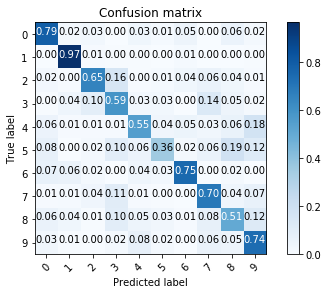

In [34]:
cm = metrics.confusion_matrix(y_true, y_pred)
accuracy=plot_confusion_matrix(cm,["0","1","2","3","4","5","6","7","8","9"],normalize=True)

In [22]:
accuracy